# Covid prediction on X-ray images

## First lets split data into train/validaton/test folders with images in 70/15/15 ratio

In [7]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
root_dir = 'X-ray'
positive_class = 'COVID'
negative_class = 'Non-COVID'

os.makedirs(root_dir +'/train/' + positive_class)
os.makedirs(root_dir +'/train/' + negative_class)
os.makedirs(root_dir +'/val/' + positive_class)
os.makedirs(root_dir +'/val/' + negative_class)
os.makedirs(root_dir +'/test/' + positive_class)
os.makedirs(root_dir +'/test/' + negative_class)

# Creating partitions of the data after shuffeling
for class_covid in [positive_class,negative_class]:
    currentCls = class_covid
    src = root_dir + "/" + currentCls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                            [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ',currentCls, len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, "X-ray/train/"+currentCls)

    for name in val_FileNames:
        shutil.copy(name, "X-ray/val/"+currentCls)

    for name in test_FileNames:
        shutil.copy(name, "X-ray/test/"+currentCls)

Total images:  COVID 4044
Training:  2830
Validation:  607
Testing:  607
Total images:  Non-COVID 5500
Training:  3849
Validation:  826
Testing:  825


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

## Upload the Data

In [2]:
# Init folder paths
directory_train = "X-ray/train"
directory_val = "X-ray/val"
directory_test = "X-ray/test"

In [3]:
# Init the data from directory
batch_size = 32
image_size = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory_train, labels='inferred', label_mode='binary', class_names=None,
    color_mode='rgb', batch_size=batch_size, image_size=image_size, shuffle=True, seed=123,
    interpolation='bilinear', follow_links=False
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory_val, labels='inferred', label_mode='binary', class_names=None,
    color_mode='rgb', batch_size=batch_size, image_size=image_size, shuffle=True, seed=123,
    interpolation='bilinear', follow_links=False
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory_test, labels='inferred', label_mode='binary', class_names=None,
    color_mode='rgb', batch_size=batch_size, image_size=image_size, shuffle=True, seed=123,
    interpolation='bilinear', follow_links=False
)

Found 6674 files belonging to 2 classes.
Found 1432 files belonging to 2 classes.
Found 1431 files belonging to 2 classes.


## Visualize The Data

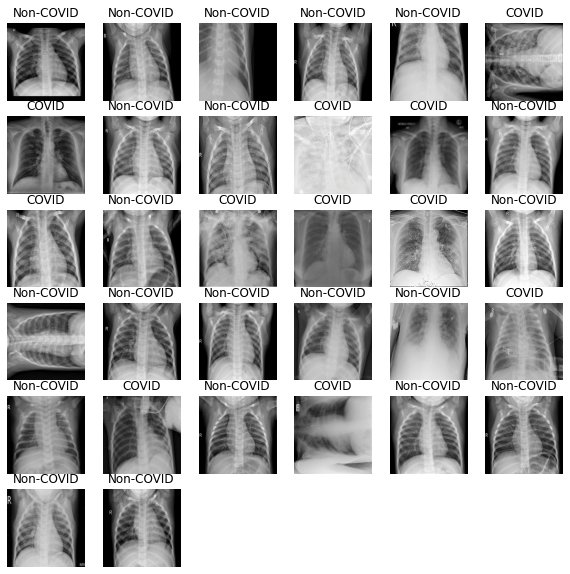

In [6]:
plt.figure(figsize=(10, 10))
class_names = test_data.class_names
for images, labels in test_data.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

## Set Callbacks

In [4]:
filepath = "Test_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    mode='max',
    monitor='val_accuracy', 
    verbose=2, 
    save_best_only=True
    )

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=4, 
    verbose=1,
    factor=0.5, 
    min_lr=0.00001
)

callbacks_list = [checkpoint,lr_plateau]

## Modeling

In [5]:
model_CNN = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, (1, 1), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (5, 5),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),padding="same"),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Dense(1, activation='sigmoid')
])


In [6]:
model_CNN.compile(
    optimizer = optimizers.Adam(learning_rate=.00025), 
    loss = 'binary_crossentropy', 
    metrics=['accuracy']
)

In [7]:
history_1 = model_CNN.fit(train_data,validation_data=val_data,callbacks=callbacks_list,epochs=10)

Epoch 1/10
209/209 [==============================] - 66s 262ms/step - loss: 0.5203 - accuracy: 0.7520 - val_loss: 44.4603 - val_accuracy: 0.5761

Epoch 00001: val_accuracy improved from -inf to 0.57612, saving model to Test_model.h5
Epoch 2/10
209/209 [==============================] - 57s 270ms/step - loss: 0.4274 - accuracy: 0.8018 - val_loss: 26.7746 - val_accuracy: 0.5964

Epoch 00002: val_accuracy improved from 0.57612 to 0.59637, saving model to Test_model.h5
Epoch 3/10
209/209 [==============================] - 57s 269ms/step - loss: 0.4177 - accuracy: 0.8070 - val_loss: 6.5634 - val_accuracy: 0.4420

Epoch 00003: val_accuracy did not improve from 0.59637
Epoch 4/10
209/209 [==============================] - 57s 269ms/step - loss: 0.3750 - accuracy: 0.8301 - val_loss: 7.3234 - val_accuracy: 0.7549

Epoch 00004: val_accuracy improved from 0.59637 to 0.75489, saving model to Test_model.h5
Epoch 5/10
209/209 [==============================] - 57s 270ms/step - loss: 0.3386 - accura

In [8]:
history_2 = model_CNN.fit(train_data,validation_data=val_data,callbacks=callbacks_list,epochs=100)

Epoch 1/100
209/209 [==============================] - 54s 257ms/step - loss: 0.1388 - accuracy: 0.9474 - val_loss: 54.7294 - val_accuracy: 0.5901

Epoch 00001: val_accuracy did not improve from 0.75489
Epoch 2/100
209/209 [==============================] - 56s 267ms/step - loss: 0.1204 - accuracy: 0.9567 - val_loss: 44.2611 - val_accuracy: 0.5922

Epoch 00002: val_accuracy did not improve from 0.75489
Epoch 3/100
209/209 [==============================] - 56s 267ms/step - loss: 0.1093 - accuracy: 0.9600 - val_loss: 23.3094 - val_accuracy: 0.5978

Epoch 00003: val_accuracy did not improve from 0.75489
Epoch 4/100
209/209 [==============================] - 56s 268ms/step - loss: 0.1005 - accuracy: 0.9630 - val_loss: 29.6994 - val_accuracy: 0.5915

Epoch 00004: val_accuracy did not improve from 0.75489
Epoch 5/100
209/209 [==============================] - 56s 268ms/step - loss: 0.1012 - accuracy: 0.9628 - val_loss: 28.5663 - val_accuracy: 0.5992

Epoch 00005: val_accuracy did not improv

KeyboardInterrupt: 

In [9]:
model_CNN.evaluate(test_data)

45/45 [==============================] - 5s 95ms/step - loss: 16.3879 - accuracy: 0.6226


[16.3879337310791, 0.6226415038108826]

## Transfer Learning

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

model_Mob = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    MobileNetV2(input_shape = (224,224,3), include_top=False),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(units=64,activation="relu"),
    layers.Dense(units=1, activation="sigmoid")
])    


In [13]:
model_Mob.compile(
    optimizer = optimizers.Adam(learning_rate=.00025), 
    loss = 'binary_crossentropy', 
    metrics=['accuracy']
)

In [15]:
history_3 = model_Mob.fit(train_data,validation_data=val_data,callbacks=callbacks_list,epochs=10)

Epoch 1/10
209/209 [==============================] - 60s 256ms/step - loss: 0.3974 - accuracy: 0.8953 - val_loss: 3.0083 - val_accuracy: 0.7011

Epoch 00001: val_accuracy did not improve from 0.75489
Epoch 2/10
209/209 [==============================] - 55s 260ms/step - loss: 0.1816 - accuracy: 0.9444 - val_loss: 4.2492 - val_accuracy: 0.6634

Epoch 00002: val_accuracy did not improve from 0.75489
Epoch 3/10
209/209 [==============================] - 55s 262ms/step - loss: 0.1016 - accuracy: 0.9658 - val_loss: 2.4011 - val_accuracy: 0.8115

Epoch 00003: val_accuracy improved from 0.75489 to 0.81145, saving model to Test_model.h5
C:\Users\monol\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 4/10
209/209 [=

In [16]:
model_Mob.evaluate(test_data)

45/45 [==============================] - 4s 90ms/step - loss: 19.7302 - accuracy: 0.6904


[19.730247497558594, 0.6904262900352478]

In [17]:
history_4 = model_Mob.fit(train_data,validation_data=val_data,callbacks=callbacks_list,epochs=100)

Epoch 1/100
209/209 [==============================] - 54s 257ms/step - loss: 0.0321 - accuracy: 0.9853 - val_loss: 7.2221 - val_accuracy: 0.7528

Epoch 00001: val_accuracy did not improve from 0.81145
Epoch 2/100
209/209 [==============================] - 54s 257ms/step - loss: 0.0259 - accuracy: 0.9870 - val_loss: 1.6904 - val_accuracy: 0.8610

Epoch 00002: val_accuracy improved from 0.81145 to 0.86103, saving model to Test_model.h5
C:\Users\monol\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 3/100
209/209 [==============================] - 55s 260ms/step - loss: 0.0234 - accuracy: 0.9876 - val_loss: 0.9888 - val_accuracy: 0.8994

Epoch 00003: val_accuracy improved from 0.86103 to 0.89944, saving model 

KeyboardInterrupt: 

In [18]:
model_Mob.evaluate(test_data)

45/45 [==============================] - 4s 80ms/step - loss: 0.2033 - accuracy: 0.9679


[0.20331385731697083, 0.9678546190261841]

## The final model has close to 97% accuracy on test data which is a good result